In [140]:
import os
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [141]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

<h3>Loading data</h3>

In [142]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [143]:
dataset_path = './dataset'
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [144]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [145]:
num_classes = len(dataset.classes)
num_classes

6

In [146]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size
train_size , val_size

(1725, 575)

In [147]:
from torch.utils.data import random_split, DataLoader
train_dataset , val_dataset = random_split(dataset, [train_size , val_size])

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = True)

In [159]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [160]:
images[0].shape

torch.Size([3, 224, 224])

In [161]:
labels[0] # this images is for coressesponding label 

tensor(4)

In [162]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..1.8731157].


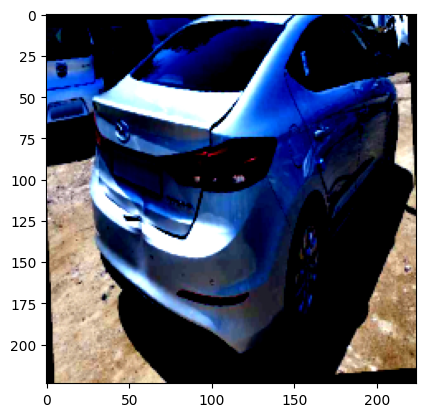

In [163]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

<h2>Model 1: CNN</h2>

In [164]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels=16, kernel_size= 3, stride = 1, padding=1), #(16, 244, 244)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0), #(16, 122, 122)
            nn.Conv2d(in_channels =16, out_channels= 32, kernel_size= 3, stride = 1, padding=1), #(16, 244, 244)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0), #(32, 56, 56)
            nn.Conv2d(in_channels = 32, out_channels= 64, kernel_size= 3, stride = 1, padding=1), #(16, 244, 244)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0), #(64, 28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.network(x)
        return x

In [165]:
# Instantite the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [166]:
len(train_loader.dataset)

1725

In [170]:
def train_model(model, criteria, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss=0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device),labels.to(device)
            #Zero the parameter gradient
            optimizer.zero_grad()

            #forword pass
            outputs = model(images)
            loss = criterion(outputs,labels)

            #Backword pass and optimization
            loss.backward()
            optimizer.step()

            if(batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            running_loss +=loss.item() * images.size(0)

        epoch_loss = running_loss /len(train_loader.dataset)
        print(f"Epoch: [{epoch+1}/{epoch}], Avg Loss: {epoch_loss: .4f}")

        #Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [171]:
# values, indices = torch.max(torch.tensor([[10, 12 , 15, 9]])

In [173]:
train_model(model, criterion , optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.47
Batch: 20, Epoch: 1, Loss: 1.10
Batch: 30, Epoch: 1, Loss: 1.29
Batch: 40, Epoch: 1, Loss: 1.22
Batch: 50, Epoch: 1, Loss: 1.40
Epoch: [1/0], Avg Loss:  1.2676
*** Validation Accuracy: 52.00% ***
Batch: 10, Epoch: 2, Loss: 1.04
Batch: 20, Epoch: 2, Loss: 0.81
Batch: 30, Epoch: 2, Loss: 1.20
Batch: 40, Epoch: 2, Loss: 0.92
Batch: 50, Epoch: 2, Loss: 1.32
Epoch: [2/1], Avg Loss:  1.0426
*** Validation Accuracy: 54.26% ***
Batch: 10, Epoch: 3, Loss: 1.30
Batch: 20, Epoch: 3, Loss: 0.88
Batch: 30, Epoch: 3, Loss: 0.85
Batch: 40, Epoch: 3, Loss: 1.08
Batch: 50, Epoch: 3, Loss: 0.91
Epoch: [3/2], Avg Loss:  0.9694
*** Validation Accuracy: 51.65% ***
Batch: 10, Epoch: 4, Loss: 0.89
Batch: 20, Epoch: 4, Loss: 1.02
Batch: 30, Epoch: 4, Loss: 1.03
Batch: 40, Epoch: 4, Loss: 1.05
Batch: 50, Epoch: 4, Loss: 1.39
Epoch: [4/3], Avg Loss:  0.9283
*** Validation Accuracy: 53.91% ***
Batch: 10, Epoch: 5, Loss: 0.62
Batch: 20, Epoch: 5, Loss: 0.76
Batch: 30, Epoch: 5, Los

([np.int64(2),
  np.int64(0),
  np.int64(3),
  np.int64(2),
  np.int64(1),
  np.int64(3),
  np.int64(4),
  np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(4),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(4),
  np.int64(4),
  np.int64(2),
  np.int64(1),
  np.int64(0),
  np.int64(5),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(5),
  np.int64(0),
  np.int64(2),
  np.int64(0),
  np.int64(5),
  np.int64(4),
  np.int64(0),
  np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(5),
  np.int64(3),
  np.int64(1),
  np.int64(5),
  np.int64(3),
  np.int64(1),
  np.int64(3),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(0),
  np.int64(4),
  np.int64(3),
  np.int64(3),
  np.int64(4),
  np.int64(2),
  np.int64(5),
  np.int64(1),
  np.int64(3),
  np.int64(2),
  np.int64(5),
  np.int64(2),
  np.int64(4),
  np.int64(1),
  np.int64(3),
  np.int64(3),
  np.int64(2),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64

<h2>Model 2: CNN with Regularization</h2>

In [174]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [ ]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 20.82
Batch: 20, Epoch: 1, Loss: 5.75
Batch: 30, Epoch: 1, Loss: 2.16
Batch: 40, Epoch: 1, Loss: 1.26
Batch: 50, Epoch: 1, Loss: 1.46
Epoch: [1/0], Avg Loss:  8.1450
*** Validation Accuracy: 47.83% ***
Batch: 10, Epoch: 2, Loss: 1.16
Batch: 20, Epoch: 2, Loss: 1.53
Batch: 30, Epoch: 2, Loss: 1.07
Batch: 40, Epoch: 2, Loss: 1.10
Batch: 50, Epoch: 2, Loss: 0.90
Epoch: [2/1], Avg Loss:  1.2820
*** Validation Accuracy: 51.48% ***
Batch: 10, Epoch: 3, Loss: 1.37
Batch: 20, Epoch: 3, Loss: 1.16
Batch: 30, Epoch: 3, Loss: 1.27
Batch: 40, Epoch: 3, Loss: 1.00
Batch: 50, Epoch: 3, Loss: 1.28
Epoch: [3/2], Avg Loss:  1.1637
*** Validation Accuracy: 51.65% ***
Batch: 10, Epoch: 4, Loss: 1.15
Batch: 20, Epoch: 4, Loss: 0.97
Batch: 30, Epoch: 4, Loss: 0.97
Batch: 40, Epoch: 4, Loss: 0.92
Batch: 50, Epoch: 4, Loss: 1.07
Epoch: [4/3], Avg Loss:  1.1480
*** Validation Accuracy: 53.04% ***
Batch: 10, Epoch: 5, Loss: 1.07
Batch: 20, Epoch: 5, Loss: 1.28
Batch: 30, Epoch: 5, Lo

<h2>Model: 3 Transfer learning with EfficientNet</h2>

In [ ]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

In [ ]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [ ]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

In [ ]:
<h2>Model 4: Transfer learning with ResNet</h2>